# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

import time

--------
### 実験設定

In [2]:
### 実験データの設定 ###
TARGET = "BCR"  # 目的変数（"GMV" or "BCR"）
DATA = "part"  # データすべてを使うか一部を使うか（"all" or "part"）
DATA_SIZE = 2000  # 訓練データとテストデータあわせたデータサイズ（母集団サイズ）
TEST_SIZE = 0.5  # テストデータの比率
THRESHOLD = 2  # 外れ値除外のための閾値


### 実験設定 ###
SAMPLE_SIZE = 100  # 標本サイズ
N_TRIALS = 10  # 試行回数（標本抽出を行う回数）
m_VALUE = 2  # 最適標本配分における各クラスタの最小標本数
RANDOM_STATE = 0  # 乱数シード

EVALUATE = "EVRR"  # "VRR" or "EVRR"
N_EXPERIMENT = 2  # 実験回数

### 実験方法 ###
# クラスタリング
CLUSTERING_METHOD_LIST = ["kmeans"]  # ["gmm", "kmeans", "xmeans"]
N_CLUSTERS = 10  # クラスタ数（Kmeans と GMM）
K_MIN = 2  # 最小クラスタ数（Xmeans)
K_MAX = 10  # 最大クラスタ数(Xmeans)

# 特徴量選択
CRITERION_LIST = [
    "none",
    "lasso",  # "lasso" を選択した場合はalphaも調節する
    "ml",
    # "ml(obj)",
    # "checking"
]  # "sil", "ml-std", "tr" はうまくいかない（使うときはコメントアウトを解除する）
SELECT_MAXIMUM_FEATURES = "yes"  # "yes" or "no"（特徴量数が MAXIMUM_FEATURES_TO_SELECT になるまで選ぶかいなか）
MAXIMUM_FEATURES_TO_SELECT = 5  # 選択される最大の特徴量(特徴量選択ありの場合)
FEATURES_LIST_CHECKING = [0]  # 特徴量を指定するとき（特徴量選択基準："checking"の場合)

# 標本配分
ALLOCATION_LIST = [
    "Proportional",
    "Post",
    "Optimal",
]


##### 各手法の名前

In [3]:
stratification_methods = list(itertools.product(CRITERION_LIST, CLUSTERING_METHOD_LIST))
METHODS_NAME_DICT = {}
for method in stratification_methods:
    if method == ("none", "kmeans"):
        METHODS_NAME_DICT[method] = "Kmeans"
    if method == ("none", "xmeans"):
        METHODS_NAME_DICT[method] = "Xmeans"
    if method == ("none", "gmm"):
        METHODS_NAME_DICT[method] = "GMM"

    if method == ("ml", "kmeans"):
        METHODS_NAME_DICT[method] = "SFS-Kmeans-TSS"
    if method == ("ml", "xmeans"):
        METHODS_NAME_DICT[method] = "SFS-Xmeans-TSS"
    if method == ("ml", "gmm"):
        METHODS_NAME_DICT[method] = "SFS-GMM-Loglikelyhood"

    # if method == ("tr", "kmeans"):
    #     METHODS_NAME_DICT[method] = "SFS-Kmeans-tr"
    # if method == ("tr", "xmeans"):
    #     METHODS_NAME_DICT[method] = "SFS-Xmeans-tr"
    # if method == ("tr", "gmm"):
    #     METHODS_NAME_DICT[method] = "SFS-GMM-tr"

    # if method == ("sil", "kmeans"):
    #     METHODS_NAME_DICT[method] = "SFS-Kmeans-silhouette"
    # if method == ("sil", "xmeans"):
    #     METHODS_NAME_DICT[method] = "SFS-Xmeans-silouette"
    # if method == ("sil", "gmm"):
    #     METHODS_NAME_DICT[method] = "SFS-GMM-silouette"

    if method == ("checking", "kmeans"):
        METHODS_NAME_DICT[method] = f"Kmeans ({FEATURES_LIST_CHECKING})"
    if method == ("checking", "xmeans"):
        METHODS_NAME_DICT[method] = f"Xmeans ({FEATURES_LIST_CHECKING})"
    if method == ("checking", "gmm"):
        METHODS_NAME_DICT[method] = f"GMM ({FEATURES_LIST_CHECKING})"

    if method == ("lasso", "kmeans"):
        METHODS_NAME_DICT[method] = "Lasso-Kmeans"
    if method == ("lasso", "xmeans"):
        METHODS_NAME_DICT[method] = "Lasso-Xmeans"
    if method == ("lasso", "gmm"):
        METHODS_NAME_DICT[method] = "Lasso-GMM"

    if method == ("ml(obj)", "kmeans"):
        METHODS_NAME_DICT[method] = "SFS-Kmeans-TSST"
    if method == ("ml(obj)", "xmeans"):
        METHODS_NAME_DICT[method] = "SFS-Xmeans-TSST"
    # if method == ("ml(obj)", "gmm"):
    #     METHODS_NAME_DICT[method] = "SFS-GMM-ml(obj)"

    # if method == ("ml-std", "kmeans"):
    #     METHODS_NAME_DICT[method] = "SFS-Kmeans-TSS-std"
    # if method == ("ml-std", "xmeans"):
    #     METHODS_NAME_DICT[method] = "SFS-Xmeans-TSS-std"
    # if method == ("ml-std", "gmm"):
    #     METHODS_NAME_DICT[method] = "SFS-GMM-ml-std"

print("METHODS_NAME_DICT", METHODS_NAME_DICT)


METHODS_NAME_DICT {('none', 'kmeans'): 'Kmeans', ('lasso', 'kmeans'): 'Lasso-Kmeans', ('ml', 'kmeans'): 'SFS-Kmeans-TSS'}


##### 辞書準備

In [4]:
TIME_DICT = {}
SELECTED_FEATURES_DICT = {}


-----------
### データの前処理（Data Preprocessing）

##### データ読み込み

In [5]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)

features_list = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]

if DATA == "all":
    df = df1
if DATA == "part":
    df = df2

##### "GMV" から新しい変数 "BCR" を作成

In [6]:
df = df.copy()
df["BCR"] = np.where(df["GMV"] > 0, 1, 0)


##### 外れ値除去

In [7]:
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data


In [8]:
df = remove_outliers_zscore(data=df, metric=TARGET, threshold=THRESHOLD)
df = df.reset_index(drop=True)  # 行を詰める

print("外れ値除外前のデータ数（訓練+テスト）:", DATA_SIZE)
print("外れ値除外後のデータ数（訓練+テスト）:", len(df))


外れ値除外前のデータ数（訓練+テスト）: 2000
外れ値除外後のデータ数（訓練+テスト）: 2000


##### 訓練データとテストデータに分割

In [9]:
X_all = df[features_list].to_numpy()
y_all = df[TARGET].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=0
)

print("訓練データのデータ数:", len(X_train))
print("テストデータのデータ数:", len(X_test))

訓練データのデータ数: 1000
テストデータのデータ数: 1000


##### 標準化

In [10]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


---------------
### Lasso で特徴量選択

In [11]:
def lasso(X: NDArray, y: NDArray, alpha: float) -> list:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    features_list = np.where(lasso.coef_ != 0)[0]
    return features_list


In [12]:
ALPHA = 0.03  # 正則化の強さ（調節する）

if "lasso" in CRITERION_LIST:
    start_time_lasso = time.time()
    features_list_lasso = lasso(X_train_std, y_train, alpha=ALPHA)
    lasso_time = time.time() - start_time_lasso

    SELECTED_FEATURES_DICT["lasso"] = features_list_lasso
    TIME_DICT["lasso"] = lasso_time

    print("選択された特徴量のインデックス(Lasso):", features_list_lasso)
    print("time for feature selection", lasso_time, "s")


選択された特徴量のインデックス(Lasso): [ 3  6 11 14]
time for feature selection 0.0019829273223876953 s


-------------
### Wrapper法でクラスタリング

##### Wrapper Class

In [13]:
class Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: int,
        n_clusters: int,
        criterion: str = "ml",
        clustering_method: str = "gmm",
        random_state: int = 0,
        select_maximum_features: str = "yes",
        k_min: int = 2,
        k_max: int = 10,
    ):
        self.maximum_features_to_select = maximum_features_to_select  # 特徴量数
        self.n_clusters = n_clusters  # クラスタ数
        self.criterion = criterion  # 特徴量選択基準
        self.clustering_method = clustering_method  # クラスタリング手法
        self.random_state = random_state
        self.select_maximum_features = select_maximum_features
        self.k_min = k_min
        self.k_max = k_max

    def fss(self, X: NDArray, y: NDArray) -> "Wrapper":
        X, y = check_X_y(X, y)
        n_all_features = X.shape[1]  # 総特徴量数

        ##### 初期化 #####
        features_score_dict = {}  # スコアの推移の確認用（キー：特徴量の数, 値：スコア）
        current_features = []  # 選択された特徴量

        # if self.criterion == "ml-std":
        #     iter = 0
        #     features_to_compare = [0]  # 比較する特徴量
        #     remaining_features = [
        #         i + 1 for i in range(n_all_features - 1)
        #     ]  # 選択されていない特徴量
        # else:
        remaining_features = list(range(n_all_features))  # 選択されていない特徴量

        if self.select_maximum_features == "no":
            best_score = -np.inf  # 初期スコア（特徴量を最大数選ぶとは限らないとき）

        ##### 特徴量選択とクラスタリング #####
        while len(current_features) < self.maximum_features_to_select:
            best_feature = None

            if self.select_maximum_features == "yes":
                best_score = -np.inf  # 初期スコア（特徴量を最大数選ぶとき）

            for feature in remaining_features:
                temp_features = current_features + [
                    feature
                ]  # スコアを調べたい特徴量サブセット

                # if self.criterion == "ml-std":
                #     iter += 1
                #     score_current, labels_current, n_clusters_current = (
                #         self.crit_std_current(
                #             X[:, features_to_compare], X[:, temp_features], y
                #         )
                #     )
                #     score_temp, labels_temp, n_clusters_temp = self.crit_std_temp(
                #         X[:, features_to_compare], X[:, temp_features], y
                #     )
                #     if (score_temp > score_current) or (
                #         self.select_maximum_features == "yes" and best_feature is None
                #     ):
                #         best_feature = feature
                #         features_to_compare = temp_features
                #         best_score = score_temp
                #         best_labels = labels_temp
                #         best_n_clusters = n_clusters_temp
                #     elif iter == 1:
                #         best_feature = 0
                #         features_to_compare = [0]
                #         best_score = score_current
                #         best_labels = labels_current
                #         best_n_clusters = n_clusters_current
                # else:
                score, labels, n_clusters = self.crit(X[:, temp_features], y)
                if score > best_score:
                    best_score = score
                    best_feature = feature
                    best_labels = labels
                    best_n_clusters = n_clusters

            # 選択された特徴量をcurrent_featuresに追加し、remaining_features から除外
            if best_feature is not None:
                current_features.append(best_feature)
                if best_feature in remaining_features:
                    remaining_features.remove(best_feature)

                num_of_features = len(current_features)
                print(
                    "num_of_features:",
                    num_of_features,
                    "current_features:",
                    current_features,
                    ", score:",
                    best_score,
                    "best_n_clusters:",
                    best_n_clusters,
                )
                features_score_dict[str(num_of_features)] = best_score  # 確認用

            else:
                break

        ##### 最終的な特徴量とクラスタリング結果 #####
        self.selected_features_index = current_features
        self.final_cluster_assignments = best_labels
        self.final_n_clusters = best_n_clusters
        self.features_score_dict = features_score_dict

        return self

    def crit(self, X: NDArray, y: NDArray) -> tuple[float, list, int]:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            model = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        if self.clustering_method == "kmeans":
            model = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
        if self.clustering_method == "xmeans":
            model = self.xmeans(X)

        model.fit(X)
        labels = model.predict(X)
        n_clusters = len(np.unique(labels))

        if self.criterion == "ml":
            score = model.score(X)

        elif self.criterion == "sil":
            score = silhouette_score(X, labels)

        elif self.criterion == "ml(obj)" and (
            self.clustering_method == "kmeans" or self.clustering_method == "xmeans"
        ):
            tss = 0
            for k in np.unique(labels):
                y_k = y[labels == k]
                mean_y_k = np.mean(y_k)
                tss += np.sum((y_k - mean_y_k) ** 2)
            score = -tss

        # elif self.criterion == "tr" and self.clustering_method == "gmm":
        #     means = model.means_  # 平均ベクトル
        #     covariances = (
        #         model.covariances_ + 1e-7
        #     )  # 共分散行列(各要素に微小な数が加算される)
        #     weights = model.weights_  # 混合比率
        #     overall_mean = np.sum(
        #         weights[:, np.newaxis] * means, axis=0
        #     )  # 標本平均 #np.newaxisを使って1次元配列から2次元配列にする
        #     S_W = np.sum(weights[:, np.newaxis, np.newaxis] * covariances, axis=0)
        #     S_B = np.sum(
        #         weights[:, np.newaxis, np.newaxis]
        #         * np.einsum(
        #             "...i,...j->...ij", means - overall_mean, means - overall_mean
        #         ),
        #         axis=0,
        #     )
        #     score = np.trace(np.linalg.solve(S_W, S_B))

        # elif self.criterion == "tr" and and (self.clustering_method == "kmeans" or self.clustering_method=="xmeans"):
        #     cluster_centers = model.cluster_centers_
        #     sw_i_list = []
        #     for i in range(n_clusters):
        #         cluster_points = X[labels == i]
        #         if cluster_points.shape[0] <= 2:
        #             # データポイントが1つの場合はゼロ行列を使用
        #             sw_i = np.zeros((X.shape[1], X.shape[1])) + 1e-7
        #         else:
        #             sw_i = (np.cov(cluster_points, rowvar=False) + 1e-7) * np.sum(
        #                 labels
        #                 == i  # データ数を重みに使う代わりにデータの割合を使う
        #             )
        #             if np.isscalar(sw_i):  # スカラー値のとき
        #                 sw_i = np.array([[sw_i]])
        #         sw_i_list.append(sw_i)
        #     # 全クラスターの S_W を合計
        #     S_W = np.sum(sw_i_list, axis=0)
        #     # クラスター間散布行列 S_B を計算
        #     overall_mean = np.mean(X, axis=0)
        #     S_B = sum(
        #         (np.sum(labels == i) / X.shape[0])  # 割合にする
        #         * np.outer(
        #             cluster_centers[i] - overall_mean,
        #             cluster_centers[i] - overall_mean,
        #         )
        #         # *(cluster_centers[i] - overall_mean) @ (cluster_centers[i] - overall_mean).T
        #         for i in range(n_clusters)
        #     )
        #     # 散乱分離性を計算
        #     score = np.trace(np.linalg.solve(S_W, S_B))

        return score, labels, n_clusters

    # def crit_std_current(self, current_X, temp_X, y):
    #     score_current, labels, n_clusters = self.crit_std(current_X, current_X)
    #     score_temp, _, _ = self.crit_std(temp_X, current_X)
    #     score = -score_current * score_temp
    #     return score, labels, n_clusters

    # def crit_std_temp(self, current_X, temp_X, y):
    #     score_current, _, _ = self.crit_std(current_X, temp_X)
    #     score_temp, labels, n_clusters = self.crit_std(temp_X, temp_X)
    #     score = -score_current * score_temp
    #     return score, labels, n_clusters

    # def crit_std(self, X1, X2):  # X2空間上でしたクラスタリングの結果をX1空間上で評価
    #     if self.clustering_method == "kmeans" or self.clustering_method == "xmeans":
    #         if self.clustering_method == "kmeans":
    #             model = KMeans(
    #                 n_clusters=self.n_clusters,
    #                 random_state=self.random_state,
    #             )
    #         if self.clustering_method == "xmeans":
    #             model = self.xmeans(X2)

    #         model.fit(X2)
    #         labels = model.predict(X2)
    #         n_clusters = len(np.unique(labels))

    #         # クラスタラベルを使ってX1空間上でのSSEを計算
    #         centroids_X1 = np.zeros((n_clusters, X1.shape[1]))  # クラスタ数 × X1の次元
    #         for i in range(n_clusters):
    #             # 各クラスタのデータ点の平均を計算（X1空間上）
    #             cluster_points = X1[labels == i]
    #             centroids_X1[i, :] = np.mean(cluster_points, axis=0)

    #         # 総平方和(SSE)を計算
    #         sse = 0.0
    #         for i, label in enumerate(labels):
    #             centroid = centroids_X1[label]  # データポイントに対応するクラスタの重心
    #             sse += np.sum(
    #                 (X1[i] - centroid) ** 2
    #             )  # データ点と重心の距離の二乗を加算
    #         score = sse

    #         return score, labels, n_clusters

    def compute_bic(self, X: NDArray, kmeans: KMeans) -> float:
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X: NDArray) -> KMeans:
        kmeans = KMeans(
            n_clusters=self.k_min, random_state=self.random_state
        )  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def get_selected_features_index(self) -> list:
        return self.selected_features_index  # 最終的に選択された特徴量のインデックス

    def get_final_cluster_assignments(self) -> list:
        return self.final_cluster_assignments  # 最終的なクラスタリング結果

    def get_final_n_clusters(self) -> int:
        return self.final_n_clusters  # 最終的なクラスタ数

    def get_features_score_dict(self) -> dict:
        return self.features_score_dict  # スコアの推移（確認用）

##### Wrapper class を適用する関数

In [14]:
def process_wrapper(
    instance: "Wrapper", X: NDArray, y: NDArray
) -> tuple[list, list, list, dict, int]:
    instance.fss(X, y)
    selected_features_index = instance.get_selected_features_index()
    cluster_label = instance.get_final_cluster_assignments()
    cluster_size = np.unique(cluster_label, return_counts=True)[1]
    features_score_dict = instance.get_features_score_dict()
    n_clusters = instance.get_final_n_clusters()

    return (
        selected_features_index,
        cluster_label,
        cluster_size,
        features_score_dict,
        n_clusters,
    )


##### インスタンス作成

In [15]:
# Wrapperインスタンスのリスト
instances = []
for method, name in METHODS_NAME_DICT.items():
    if method[0] != "none" and method[0] != "checking" and method[0] != "lasso":
        instances.append(
            (
                name,
                Wrapper(
                    maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
                    n_clusters=N_CLUSTERS,
                    criterion=method[0],
                    clustering_method=method[1],
                    random_state=RANDOM_STATE,
                    select_maximum_features=SELECT_MAXIMUM_FEATURES,
                    k_min=K_MIN,
                    k_max=K_MAX,
                ),
            )
        )
print(instances)


[('SFS-Kmeans-TSS', Wrapper(clustering_method='kmeans', maximum_features_to_select=5, n_clusters=10))]


In [16]:
# 辞書の初期化
# cluster_label_dict_train = {}
# cluster_size_dict_train = {}
# N_CLUSTER_DICT_train = {}
features_score_dict_list = []

# 各インスタンスに対して処理を実行
for name, instance in instances:
    print("[", name, "]")
    start_time = time.time()

    (
        selected_features_index,
        cluster_label,
        cluster_size,
        features_score_dict,
        n_clusters,
    ) = process_wrapper(instance, X_train_std, y_train)

    end_time = time.time()
    TIME_DICT[name] = end_time - start_time

    # cluster_label_dict_train[name] = cluster_label
    # cluster_size_dict_train[name] = cluster_size
    # N_CLUSTER_DICT_train[name] = n_clusters
    features_score_dict_list.append(features_score_dict)

    SELECTED_FEATURES_DICT[name] = selected_features_index

    print("選ばれた特徴量：", selected_features_index)
    print("最終的な各層のクラスタサイズ : ", cluster_size)


[ SFS-Kmeans-TSS ]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


num_of_features: 1 current_features: [2] , score: -1.567713137707032e-27 best_n_clusters: 2
num_of_features: 2 current_features: [2, 6] , score: -2.441086193233325 best_n_clusters: 10
num_of_features: 3 current_features: [2, 6, 1] , score: -47.03636183222697 best_n_clusters: 10
num_of_features: 4 current_features: [2, 6, 1, 5] , score: -131.5484581497983 best_n_clusters: 10
num_of_features: 5 current_features: [2, 6, 1, 5, 4] , score: -259.01759555956863 best_n_clusters: 10
選ばれた特徴量： [2, 6, 1, 5, 4]
最終的な各層のクラスタサイズ :  [269 314   1 198   1   1   4   1   5 206]


##### Wrapper法のスコア推移

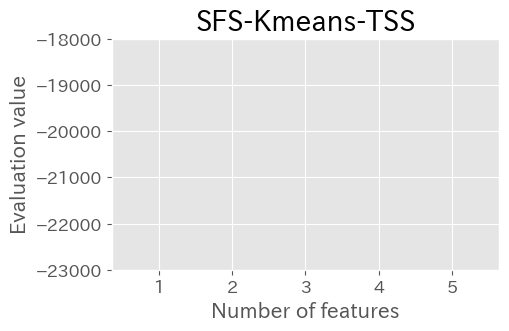

In [17]:
i = -1
for name, instance in instances:
    i += 1
    # 棒グラフを作成
    plt.figure(figsize=(5, 3))
    plt.bar(features_score_dict_list[i].keys(), features_score_dict_list[i].values())
    plt.title(f"{name}", fontsize=20)
    plt.xlabel("Number of features", fontsize=15)
    plt.ylabel("Evaluation value", fontsize=15)
    plt.ylim(-23000, -18000)
    plt.tick_params(axis="both", labelsize=12.5)
    plt.show()

---------------
### 選ばれた特徴量と計算時間

In [18]:
print(SELECTED_FEATURES_DICT)
print(TIME_DICT)

{'lasso': array([ 3,  6, 11, 14], dtype=int64), 'SFS-Kmeans-TSS': [2, 6, 1, 5, 4]}
{'lasso': 0.0019829273223876953, 'SFS-Kmeans-TSS': 2.9099669456481934}


-------------
----------
### テストデータで評価

----------------
### クラスタリング

##### 準備（Xmeans）

In [19]:
def compute_bic(X, kmeans):
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_kmeans = kmeans
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        if current_bic < best_bic:
            best_bic = current_bic
            best_kmeans = kmeans
    return best_kmeans

##### クラスタリング結果

In [20]:
cluster_label_dict_test = {}
cluster_size_dict_test = {}
N_CLUSTER_DICT_test = {}

clustering_methods = []
for method, name in METHODS_NAME_DICT.items():
    clustering_methods.append(name)
    if method[1] == "kmeans":
        model = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
    if method[1] == "gmm":
        model = GaussianMixture(
            n_components=N_CLUSTERS, random_state=RANDOM_STATE, init_params="kmeans"
        )
    if method[1] == "xmeans":
        model = xmeans(X_test_std, k_min=K_MIN, k_max=K_MAX)

    if method[0] == "none":
        labels = model.fit_predict(X_test_std)
    if method[0] == "checking":
        labels = model.fit_predict(X_test_std[:, FEATURES_LIST_CHECKING])
    if method[0] == "lasso":
        labels = model.fit_predict(X_test_std[:, SELECTED_FEATURES_DICT["lasso"]])
    elif method[0] != "none" and method[0] != "checking":
        labels = model.fit_predict(X_test_std[:, SELECTED_FEATURES_DICT[name]])

    cluster_size = np.bincount(labels)
    n_clusters = len(np.unique(labels))

    cluster_label_dict_test[name] = labels
    cluster_size_dict_test[name] = cluster_size
    N_CLUSTER_DICT_test[name] = n_clusters

    print("[", name, "]")
    print("各層のクラスタサイズ : ", cluster_size_dict_test[name])
    print("クラスタ数：", N_CLUSTER_DICT_test[name])
    print()

[ Kmeans ]
各層のクラスタサイズ :  [213  62  29  53 147  19  92   4  74 307]
クラスタ数： 10

[ Lasso-Kmeans ]
各層のクラスタサイズ :  [118 142 168  92  53  26 216  97  23  65]
クラスタ数： 10

[ SFS-Kmeans-TSS ]
各層のクラスタサイズ :  [ 94 252 221   6  45 132 218   4  20   8]
クラスタ数： 10



-----------------------------
### 標本配分（Allocation)

##### 基底クラス（層化抽出）

In [21]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        sample_size: int,
        H: int,
        random_state: int,
        criterion: str,
        clustering_method: str,
        methods_name_dict: dict,
    ):
        self.sample_size = sample_size
        self.H = H
        self.random_state = random_state
        self.criterion = criterion
        self.clustering_method = clustering_method
        self.methods_name_dict = methods_name_dict

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        for method, name in self.methods_name_dict.items():
            if method[0] == self.criterion and method[1] == self.clustering_method:
                cluster_label = cluster_label_dict_test[name]
                cluster_size = cluster_size_dict_test[name]

        # インスタンス変数として設定
        self.cluster_label = cluster_label
        self.N = cluster_size

        return cluster_label, cluster_size

##### 比例配分のクラス

In [22]:
class Proportional(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.sample_size).astype(int)

        if n.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.sample_size

        if n.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n[np.argmax(n)] += -n.sum() + self.sample_size

        return n

##### 事後層化のクラス

In [23]:
class Post(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])

        return n  # （例）n=[標本サイズ]

##### 最適標本配分のクラス

In [24]:
class Optimal(BaseAllocation):
    def __init__(
        self,
        sample_size: int,
        H: int,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
        random_state: int = 0,
        criterion: str = "tr",
        clustering_method: str = "kmeans",
        methods_name_dict: dict = {},
    ):
        super().__init__(
            sample_size,
            H,
            random_state,
            criterion,
            clustering_method,
            methods_name_dict,
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

##### 各ポリシーを生成

In [25]:
# 各ポリシーの生成を行う関数
def create_policies(
    methods_name_dict: dict,
    allocation_list: list,
    sample_size: int,
    H_dict: dict,
    random_state: int,
    m_value: int,
):  # -> dict[list[str] : list[BaseAllocation]]:
    policies_dict = {}
    for method, name in methods_name_dict.items():
        policies: list[BaseAllocation] = []
        if "Proportional" in allocation_list:
            policies.append(
                Proportional(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        if "Post" in allocation_list:
            policies.append(
                Post(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        if "Optimal" in allocation_list:
            policies.append(
                Optimal(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    m=np.full(H_dict[name], m_value),
                    M=None,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        policies_dict[name] = policies
    return policies_dict


policies_dict = create_policies(
    methods_name_dict=METHODS_NAME_DICT,
    allocation_list=ALLOCATION_LIST,
    sample_size=SAMPLE_SIZE,
    H_dict=N_CLUSTER_DICT_test,
    random_state=RANDOM_STATE,
    m_value=m_VALUE,
)

print("policies_dict", policies_dict)

policies_dict {'Kmeans': [<__main__.Proportional object at 0x000001A16A895550>, <__main__.Post object at 0x000001A14DE13980>, <__main__.Optimal object at 0x000001A16B456510>], 'Lasso-Kmeans': [<__main__.Proportional object at 0x000001A16B454740>, <__main__.Post object at 0x000001A16B4578F0>, <__main__.Optimal object at 0x000001A16B454A10>], 'SFS-Kmeans-TSS': [<__main__.Proportional object at 0x000001A16B442B40>, <__main__.Post object at 0x000001A16B441BE0>, <__main__.Optimal object at 0x000001A16B442600>]}


##### 標本配分の計算

In [26]:
allocations_dict = {}
for name, policies in policies_dict.items():
    # それぞれの戦略で各クラスタの標本数を求解
    allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
    for policy in policies:
        # policyを用いてXをクラスタリング
        cluster_label, _ = policy.clustering(X_test_std)
        n = policy.solve(X_test_std, y_test)
        allocations.append(
            {
                "policy": policy.__class__.__name__,
                "n": n,
                "cluster_label": cluster_label,
            }
        )
    allocations_dict[name] = allocations

------------
### 標本抽出と誤差分散削減率の計算

##### 母平均を推定する関数

In [27]:
def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        if n[h] != 0:
            y_cluster = y[cluster_label == h]
            if n[h] <= len(y_cluster):
                sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
                y_sample_mean = sample.mean()  # サンプリングした標本の平均
                y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    indices = np.arange(N.sum())
    y_array = np.array(y.tolist())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new_labels = np.unique(n_label)
    for h in n_new_labels:
        index = np.where(n_label == h)[0]
        sample = y_array[n_indices[index]]
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat

##### 誤差分散削減率の計算する関数

In [28]:
def cauculate_reduction_rate(
    X: pd.DataFrame,
    y: pd.DataFrame,
    policies_dict: dict,
    random_std: float,
) -> dict:
    reduction_rate_dict = {}
    variance_dict = {}

    # 各戦略の標本数に基づいて目的変数の平均を推定
    y_hats_dict = {}
    for name, allocations in allocations_dict.items():
        y_hats = []
        for i in range(N_TRIALS):
            for allocation in allocations:
                if allocation["policy"] == "Post":
                    y_hat = estimate_y_mean_post(
                        allocation["n"], allocation["cluster_label"], y
                    )
                else:
                    y_hat = estimate_y_mean(
                        allocation["n"], allocation["cluster_label"], y
                    )
                y_hats.append(
                    {
                        "policy": allocation["policy"],
                        "y_hat": y_hat,
                        "random_state": i,
                    }
                )
        y_hats_dict[name] = y_hats

    for name, y_hats in y_hats_dict.items():
        y_hat_df = pd.DataFrame(y_hats)
        if EVALUATE == "EVRR":
            y_hat_df["error"] = (
                y_hat_df["y_hat"] - y.mean()
            )  # 真の平均からの誤差をerrorカラムに追加
            # random_allocation以外の誤差分散
            non_random_allocation_std = y_hat_df.groupby("policy")["error"].var()
            # 削減率
            reduction_rate = (1 - non_random_allocation_std / random_std) * 100
        if EVALUATE == "VRR":
            non_random_allocation_std = y_hat_df.groupby("policy")["y_hat"].var()
            reduction_rate = (1 - non_random_allocation_std / random_std) * 100

        reduction_rate = reduction_rate.reindex(
            [policy.__class__.__name__ for policy in policies]
        )

        variance = pd.concat(
            [
                pd.Series(random_std, index=["Random"]),
                non_random_allocation_std,
            ]
        )

        reduction_rate_dict[name] = reduction_rate
        variance_dict[name] = variance
    return reduction_rate_dict, variance_dict

##### 実験回数分の誤差分散削減率を計算（単純無作為抽出）

In [29]:
RANDOM_STD_LIST = []
for exp in range(N_EXPERIMENT):
    np.random.seed(i)
    y_hats = []
    for random_state in range(N_TRIALS):
        sample = np.random.choice(y_test, SAMPLE_SIZE, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    if EVALUATE == "EVRR":
        errors = np.array(y_hats) - y_test.mean()
        random_std = errors.var()
    if EVALUATE == "VRR":
        random_std = np.array(y_hats).var()
    RANDOM_STD_LIST.append(random_std)
print(RANDOM_STD_LIST)

[0.002256, 0.002256]


##### 実験回数分の誤差分散削減率を計算（層化抽出）

In [30]:
all_reduction_rate = []
all_variance = []
for exp in range(N_EXPERIMENT):
    np.random.seed(exp)
    reduction_rate_dict, variance_dict = cauculate_reduction_rate(
        X_test_std, y_test, policies_dict, RANDOM_STD_LIST[exp]
    )
    all_reduction_rate.append(reduction_rate_dict)
    all_variance.append(variance_dict)

In [31]:
results_reduction_rate_list = []
results_variance_list = []

for exp in range(N_EXPERIMENT):
    results_reduction_rate = {}
    results_variance = {}

    for name, policy in all_reduction_rate[exp].items():
        results_reduction_rate[name] = {}
        for allocation_method in ALLOCATION_LIST:
            results_reduction_rate[name][allocation_method] = policy[allocation_method]

    results_variance["Random"] = RANDOM_STD_LIST[exp]
    for name, policy in all_variance[exp].items():
        results_variance[name] = {}
        for allocation_method in ALLOCATION_LIST:
            results_variance[name][allocation_method] = policy[allocation_method]

    results_reduction_rate_list.append(results_reduction_rate)
    results_variance_list.append(results_variance)

------------------
### 可視化

In [32]:
def plot_bars(dicts, titles, figsize=(8, 2.5)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    if EVALUATE == "EVRR":
        ylabels = ["EV reduction rate", "EV"]
    if EVALUATE == "VRR":
        ylabels = ["Var reduction rate", "Var"]
    if TARGET == "GMV":
        ylims = [(0, 40), (0, 500000)]
    if TARGET == "BCR":
        ylims = [(0, 40), (0, 0.003)]

    for i, ax in enumerate(axs):
        data = list(dicts[i].values())
        labels = list(dicts[i].keys())
        bars = ax.bar(labels, data)
        for bar in bars:
            yval = bar.get_height()  # 各バーの高さ（値）
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                round(yval, 2),
                ha="center",
                va="bottom",
                fontsize=15,
            )  # 値をバーの上に表示
        if i == 1 and "Random" not in labels:
            random_bar = ax.bar("ran", random_std, color="blue")
            yval = random_bar[0].get_height()
            ax.text(
                random_bar[0].get_x() + random_bar[0].get_width() / 2,
                yval,
                round(yval, 2),
                ha="center",
                va="bottom",
                fontsize=15,
            )
        ax.set_title(titles[i], fontsize=20)
        ax.set_ylabel(ylabels[i], fontsize=15)
        ax.tick_params(axis="both", which="major", labelsize=12.5)
        ax.set_ylim(ylims[i])
    plt.tight_layout()
    plt.show()


def plot_boxplots(dicts, titles, figsize=(8, 2.5)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    if EVALUATE == "EVRR":
        ylabels = ["EV reduction rate", "EV"]
    if EVALUATE == "VRR":
        ylabels = ["Var reduction rate", "Var"]
    if TARGET == "GMV":
        ylims = [(0, 40), (0, 500000)]
    if TARGET == "BCR":
        ylims = [(0, 40), (0, 0.003)]
    for i, ax in enumerate(axs):
        data = list(dicts[i].values())
        labels = list(dicts[i].keys())
        ax.boxplot(data, labels=labels)
        ax.set_title(titles[i], fontsize=20)
        ax.set_ylabel(ylabels[i], fontsize=15)
        ax.tick_params(axis="both", which="major", labelsize=12.5)
        ax.set_ylim(*ylims[i])
    plt.tight_layout()  # レイアウトを調整
    plt.show()

##### 分布を確認  

{'Kmeans': {'Proportional': [0.002429310518481779, 0.0008520517871140244], 'Post': [0.0022918401296270863, 0.0025098582787756053], 'Optimal': [0.0012255241625684467, 0.0010740591981430467]}, 'Lasso-Kmeans': {'Proportional': [0.0018762781223589263, 0.0021270064734440295], 'Post': [0.0016133363295924511, 0.0017186718677124247], 'Optimal': [0.0018312527538774342, 0.00140284910638046]}, 'SFS-Kmeans-TSS': {'Proportional': [0.0031780049340056626, 0.003238830132047202], 'Post': [0.0026570321912258057, 0.0017626946031989003], 'Optimal': [0.0016466941428338912, 0.0025686696485419853]}}


C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22236\185233403.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22236\185233403.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)


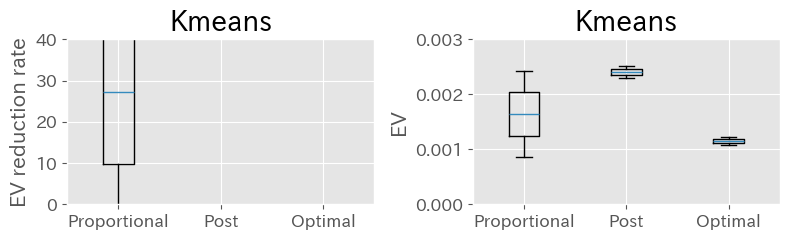

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22236\185233403.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22236\185233403.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)


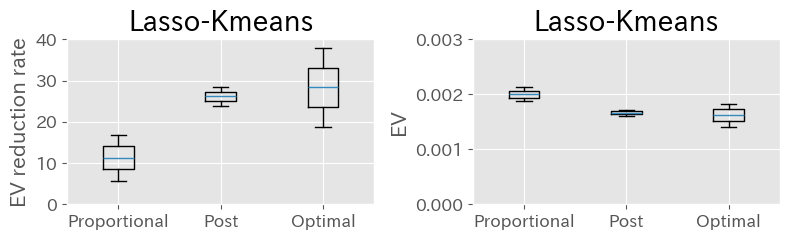

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22236\185233403.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22236\185233403.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)


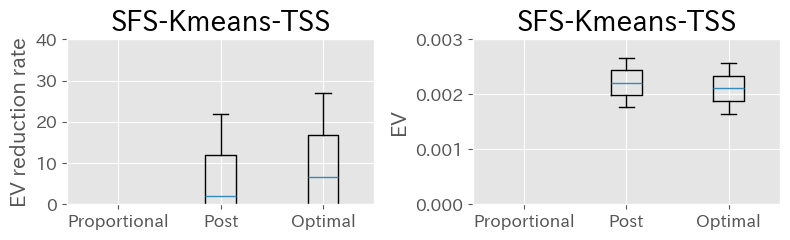

In [33]:
boxplot_reduction_rate = {}
boxplot_variance = {}

for method in list(results_reduction_rate_list[0].keys()):
    boxplot_reduction_rate[method] = {}
    boxplot_variance[method] = {}
    for allocation_method in ALLOCATION_LIST:
        boxplot_reduction_rate[method][allocation_method] = []
        boxplot_variance[method][allocation_method] = []

        for exp in range(N_EXPERIMENT):
            boxplot_reduction_rate[method][allocation_method].append(
                results_reduction_rate_list[exp][method][allocation_method]
            )
            boxplot_variance[method][allocation_method].append(
                results_variance_list[exp][method][allocation_method]
            )
print(boxplot_variance)

for method in list(results_reduction_rate_list[0].keys()):
    plot_boxplots(
        dicts=[boxplot_reduction_rate[method], boxplot_variance[method]],
        titles=[
            f"{method}",
            f"{method}",
        ],
    )

exp_num :  0


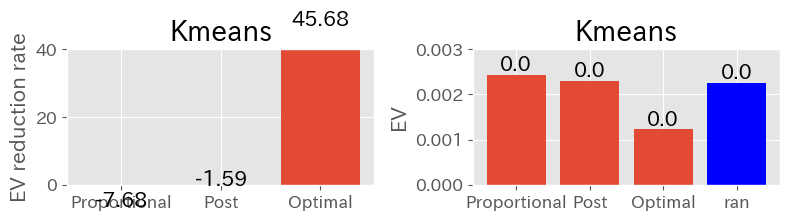

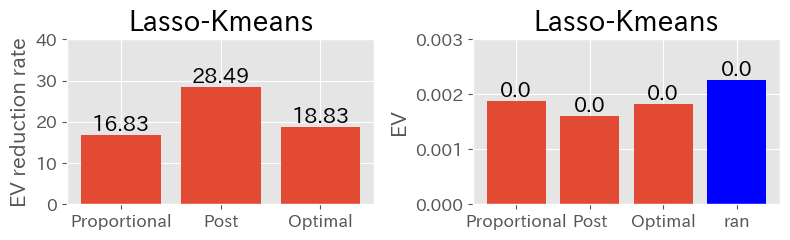

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22236\185233403.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


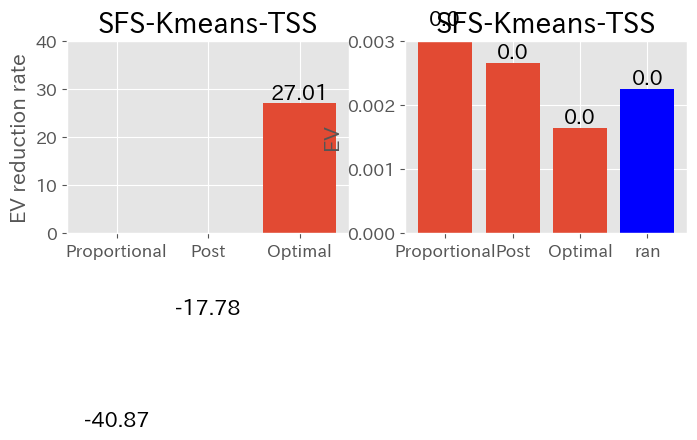

exp_num :  1


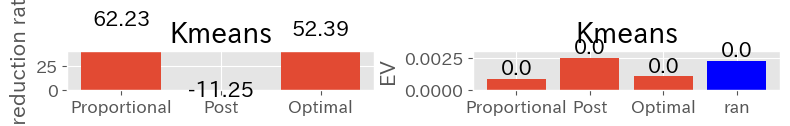

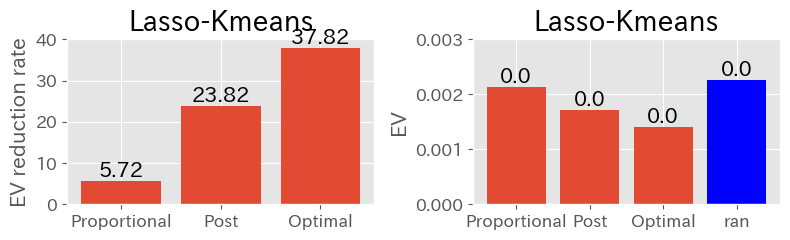

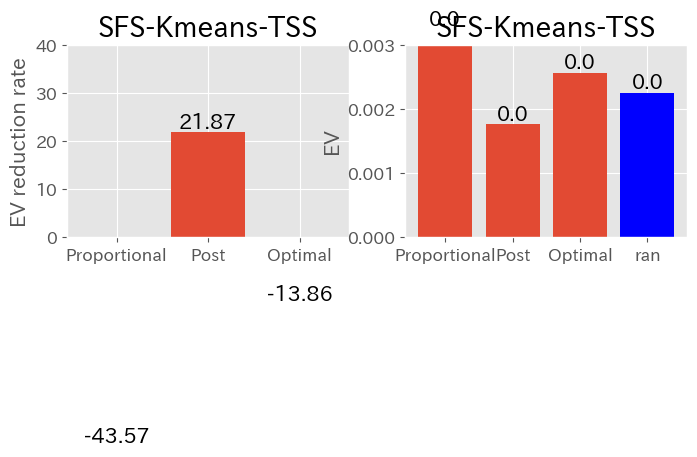

In [34]:
for exp in range(N_EXPERIMENT):
    print("exp_num : ", exp)
    for method in list(results_reduction_rate_list[0].keys()):
        plot_bars(
            dicts=[
                results_reduction_rate_list[exp][method],
                results_variance_list[exp][method],
            ],
            titles=[f"{method}", f"{method}"],
        )